### Specify the simulation directory and the target file number to analyze

In [66]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import simpson
from scipy.integrate import simps
from scipy.constants import c, pi, e, m_e, epsilon_0
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


### Below directories are the best witness beam acceleration

In [67]:
# IMPORTANT - Set these parameters 
witness_directory = '/home/novac/Desktop/my_projects/qv3d-automation/data/lag3.9/density-1e16'
driver_directory = '/home/novac/Desktop/my_projects/qv3d-automation/data/onlyDriver/density-1e16'
parent_directory = '/home/novac/Desktop/my_projects/qv3d-automation'
synchrotron_dotpy = os.path.join(parent_directory, 'pyScripts', 'synchrotron.py')

file_number = 6
fontsize = 12
fontsize14 = 14

In [68]:
if file_number < 10:
    file_name = 'v3d_synchrotron_0000' + str(file_number) + '.h5'
elif file_number < 100:
    file_name = 'v3d_synchrotron_000' + str(file_number) + '.h5'
elif file_number < 1000:
    file_name = 'v3d_synchrotron_00' + str(file_number) + '.h5'
else:
    print('ERROR: check the file_number.')

# Get the parent directory
#parent_directory = os.path.abspath(os.path.join(simulation_directory, os.pardir))
parent_directory = '/home/novac/Desktop/my_projects/qv3d-automation'
file_path_witness = os.path.join(witness_directory, file_name)
file_path_onlyDriver = os.path.join(driver_directory, file_name)
synchrotron_dotpy = os.path.join(parent_directory, 'pyScripts', 'synchrotron.py')


In [69]:
synch_integrated = !python {synchrotron_dotpy} {file_path_witness}
#synch[0]

In [70]:
my_dict = eval(synch_integrated[0])

# Convert NumPy arrays
for key, value in my_dict.items():
    if isinstance(value, np.ndarray):
        my_dict[key] = value.tolist()
        
keys = my_dict.keys()
print(keys) 

dict_keys(['criticalEnergy', 'Nphoton_Energy', 'Nphoton_Theta', 'Nphoton_Phi', 'Energy', 'Theta', 'Phi', 'phase'])


In [71]:
criticalEnergys = my_dict['criticalEnergy']
Nphotons_Energy = my_dict['Nphoton_Energy']
Nphotons_Theta  = my_dict['Nphoton_Theta']
Nphotons_Phi    = my_dict['Nphoton_Phi']
Energy          = my_dict['Energy']
Theta           = my_dict['Theta']
Phi             = my_dict['Phi']
phase           = my_dict['phase']

# Driver

In [72]:
synch_driver = !python {synchrotron_dotpy} {file_path_onlyDriver}

my_dict = eval(synch_driver[0])

# Convert NumPy arrays
for key, value in my_dict.items():
    if isinstance(value, np.ndarray):
        my_dict[key] = value.tolist()
        
keys = my_dict.keys()
#print(keys) 

criticalEnergys_driver = my_dict['criticalEnergy']
Nphotons_Energy_driver = my_dict['Nphoton_Energy']
Nphotons_Theta_driver  = my_dict['Nphoton_Theta']
Nphotons_Phi_driver    = my_dict['Nphoton_Phi']
Energy_driver          = my_dict['Energy']
Theta_driver           = my_dict['Theta']
Phi_driver             = my_dict['Phi']
phase_driver           = my_dict['phase']

# witness

In [73]:
Nphotons_Energy_witness = np.array(Nphotons_Energy) - np.array(Nphotons_Energy_driver)
Nphotons_Theta_witness = np.array(Nphotons_Theta) - np.array(Nphotons_Theta_driver)
Nphotons_Phi_witness = np.array(Nphotons_Phi) - np.array(Nphotons_Phi_driver)


In [74]:
def plot_spectrum(Nphotons_Energy, Energy):
    fig,ax = plt.subplots(figsize=(8,5))
    fig.tight_layout(pad=4.) #set the spacing between subplots

    #n0 = 7e14*1e6  # /m3 maximum plasma density
    #wp = np.sqrt(n0*e**2/epsilon_0/m_e)
    #dist = phase/wp * c

    ax.loglog(Energy,Nphotons_Energy,c='b') # photon number ~ beta oscillations * number of electrons

    ax.set_xlabel('Photon energy [eV]', fontsize=fontsize)
    ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize)
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylim(1,2e7)
    ax.set_xlim(1,1e5)

    ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
    locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())

    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    plt.savefig("synchrotron-singleFile-spectrum.pdf", dpi=100, bbox_inches='tight')
    plt.savefig("synchrotron-singleFile-spectrum.png", dpi=100, bbox_inches='tight')
    
# ###############################################################################
def integrate_array_with_respect_to_array(array1, array2, start_index, end_index):
    """
    Integrate array1 with respect to array2 between two specified indices using Simpson's rule.

    Parameters:
        array1 (array-like): Array of values to integrate.
        array2 (array-like): Array of values with respect to which integration is performed.
        start_index (int): Start index for integration.
        end_index (int): End index for integration.

    Returns:
        float: Integral of array1 with respect to array2 between the specified indices.
    """
    # Slice the arrays between start and end indices
    array1_slice = array1[start_index:end_index+1]
    array2_slice = array2[start_index:end_index+1]

    # Perform numerical integration using Simpson's rule
    integral = simps(array1_slice, array2_slice)

    return integral

# ############################################
def plot_spectrum_regions(Nphotons_Energy, Energy):
    x_initenergy = 124 #eV
    uv_initenergy = 3.1 #eV

    # Calculate all photons
    start_index = 0            # Start index for integration
    end_index = len(Energy)    # End index for integration
    all_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, end_index)
    #print('ALL photons number: ', (all_photons))
    #print('ALL photons number: ', "{0:.1E}".format(all_photons))

    for i in range(end_index):
        if Energy[i] >= uv_initenergy:
            uv_index = i
            break
    for i in range(end_index):
        if Energy[i] >= x_initenergy:
            x_index = i
            break
    low_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, uv_index)
    #print('Low energy photons number (', "{0:.1f}".format(Energy[start_index]), '-', "{0:.1f}".format(Energy[uv_index-1]), ' eV): ', "{0:.1E}".format(low_photons))

    uv_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, uv_index, x_index-1)
    #print('UV photons number (', "{0:.1f}".format(Energy[uv_index]), '-', "{0:.1f}".format(Energy[x_index-1]), ' eV): ', "{0:.1E}".format(uv_photons))

    x_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, x_index, end_index)
    #print('X-ray photons number (', "{0:.1f}".format(Energy[x_index]), '-', "{0:.1f}".format(Energy[end_index-1]), ' eV): ', "{0:.1E}".format(x_photons))

    # PI Plot
    fig,ax = plt.subplots(figsize=(5,5))
    #fig.tight_layout(pad=2.) #set the spacing between subplots
    ##################################################
    Photons = np.array([])
    Photons = np.append(Photons, x_photons)
    Photons = np.append(Photons, uv_photons)
    Photons = np.append(Photons, low_photons)

    mylabels = ["X-ray", "UV", "Low energy photons"]
    myexplode = [0.03, 0.03, 0.03]

    ax.pie(Photons, labels = mylabels, explode = myexplode, autopct='%1.1f%%', textprops={'fontsize': 12})
    plt.savefig('synchrotron-singleFile-pichart-spectrum.png', dpi=100, bbox_inches='tight')
    plt.savefig('synchrotron-singleFile-pichart-spectrum.pdf', dpi=100, bbox_inches='tight')


def plotPhotons_theta_phi(Nphotons_Theta, Nphotons_Phi, Theta, Phi):
    fig,axs = plt.subplots(2, 1, figsize=(5,8))
    fig.tight_layout(pad=4.) #set the spacing between subplots

    ax = axs[0]
    ax.plot(Theta,Nphotons_Theta,c='b')

    ax.set_xlabel('Theta [rad]', fontsize=fontsize)
    ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize)
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylim(0,1e8)
    ax.set_xlim(1e-4, 3e-3)



    ax = axs[1]
    ax.plot(Phi,Nphotons_Phi,c='b')

    ax.set_xlabel('Phi [rad]', fontsize=fontsize)
    ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize)
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_ylim(0,1e7)

    plt.savefig('synchrotron-singleFile-Theta-and-Phi.png', dpi=100, bbox_inches='tight')
    plt.savefig('synchrotron-singleFile-Theta-and-Phi.pdf', dpi=100, bbox_inches='tight')

In [75]:
#plot_spectrum(Nphotons_Energy, Energy)
#plot_spectrum_regions(Nphotons_Energy, Energy)
#plotPhotons_theta_phi(Nphotons_Theta, Nphotons_Phi, Theta, Phi)

/tmp/ipykernel_208867/4164958001.py:48: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(array1_slice, array2_slice)


ALL photons number - INTEGRATED:  1.814E+08
ALL photons number - DRIVER:  5.555E+07
ALL photons number - DRIVER to INTEGRATED:  30.614
ALL photons number - WITNESS:  1.259E+08
ALL photons number - WITNESS to INTEGRATED:  69.386 [%]


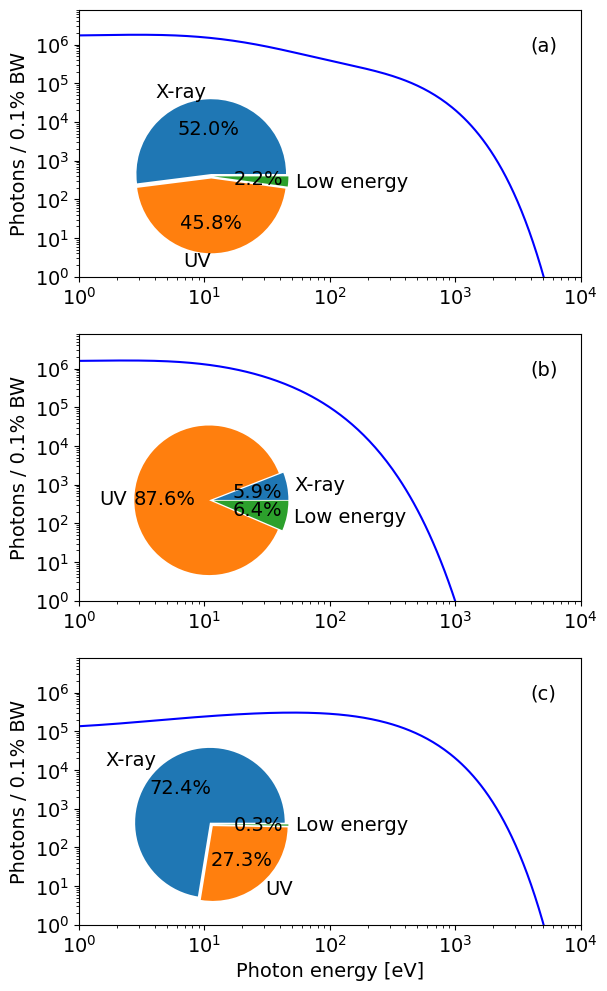

In [85]:
fig,axes = plt.subplots(3, 1, figsize=(6,10))
fig.tight_layout(pad=2.) #set the spacing between subplots

################
ax = axes[0]
ax.loglog(Energy,Nphotons_Energy,c='b') # photon number ~ beta oscillations * number of electrons

#ax.set_xlabel('Photon energy [eV]', fontsize=fontsize)
ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize14)
ax.tick_params(axis='both',labelsize=fontsize14)
ax.set_ylim(1,8e6)
ax.set_xlim(1,1e4)

ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size
#/////////////////////
# Add an inset plot in the upper-right corner
inset_ax = inset_axes(ax, width="50%", height="70%", loc="lower left")

x_initenergy = 124 #eV
uv_initenergy = 3.1 #eV

# Calculate all photons
start_index = 0            # Start index for integration
end_index = len(Energy)    # End index for integration
all_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, end_index)
all_photons_integrated = all_photons

#print('ALL photons number: ', (all_photons))
print('ALL photons number - INTEGRATED: ', "{0:.3E}".format(all_photons))

for i in range(end_index):
    if Energy[i] >= uv_initenergy:
        uv_index = i
        break
for i in range(end_index):
    if Energy[i] >= x_initenergy:
        x_index = i
        break
low_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, start_index, uv_index)
    #print('Low energy photons number (', "{0:.1f}".format(Energy[start_index]), '-', "{0:.1f}".format(Energy[uv_index-1]), ' eV): ', "{0:.1E}".format(low_photons))

uv_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, uv_index, x_index-1)
    #print('UV photons number (', "{0:.1f}".format(Energy[uv_index]), '-', "{0:.1f}".format(Energy[x_index-1]), ' eV): ', "{0:.1E}".format(uv_photons))

x_photons = integrate_array_with_respect_to_array(Nphotons_Energy, Energy, x_index, end_index)
    #print('X-ray photons number (', "{0:.1f}".format(Energy[x_index]), '-', "{0:.1f}".format(Energy[end_index-1]), ' eV): ', "{0:.1E}".format(x_photons))

# PI Plot
#fig.tight_layout(pad=2.) #set the spacing between subplots
##################################################
Photons = np.array([])
Photons = np.append(Photons, x_photons)
Photons = np.append(Photons, uv_photons)
Photons = np.append(Photons, low_photons)

mylabels = ["X-ray", "UV", "Low energy"]
myexplode = [0.03, 0.03, 0.03]

inset_ax.pie(Photons, labels = mylabels, explode = myexplode, autopct='%1.1f%%', textprops={'fontsize': 14})
#ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')

#inset_ax.set_title("Inset")
inset_ax.set_xticks([])
inset_ax.set_yticks([])

#/////////////////////

#************************************************
################
ax = axes[1]
ax.loglog(Energy_driver,Nphotons_Energy_driver,c='b') # photon number ~ beta oscillations * number of electrons

#ax.set_xlabel('Photon energy [eV]', fontsize=fontsize)
ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize14)
ax.tick_params(axis='both',labelsize=fontsize14)
ax.set_ylim(1,8e6)
ax.set_xlim(1,1e4)

ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size
#/////////////////////
# Add an inset plot in the upper-right corner
inset_ax = inset_axes(ax, width="50%", height="70%", loc="lower left")

x_initenergy = 124 #eV
uv_initenergy = 3.1 #eV

# Calculate all photons
start_index = 0            # Start index for integration
end_index = len(Energy)    # End index for integration
all_photons = integrate_array_with_respect_to_array(Nphotons_Energy_driver, Energy, start_index, end_index)
#print('ALL photons number: ', (all_photons))
print('ALL photons number - DRIVER: ', "{0:.3E}".format(all_photons))
print('ALL photons number - DRIVER to INTEGRATED: ', "{0:.3F}".format(all_photons/all_photons_integrated * 100))

for i in range(end_index):
    if Energy[i] >= uv_initenergy:
        uv_index = i
        break
for i in range(end_index):
    if Energy[i] >= x_initenergy:
        x_index = i
        break
low_photons = integrate_array_with_respect_to_array(Nphotons_Energy_driver, Energy, start_index, uv_index)
    #print('Low energy photons number (', "{0:.1f}".format(Energy[start_index]), '-', "{0:.1f}".format(Energy[uv_index-1]), ' eV): ', "{0:.1E}".format(low_photons))

uv_photons = integrate_array_with_respect_to_array(Nphotons_Energy_driver, Energy, uv_index, x_index-1)
    #print('UV photons number (', "{0:.1f}".format(Energy[uv_index]), '-', "{0:.1f}".format(Energy[x_index-1]), ' eV): ', "{0:.1E}".format(uv_photons))

x_photons = integrate_array_with_respect_to_array(Nphotons_Energy_driver, Energy, x_index, end_index)
    #print('X-ray photons number (', "{0:.1f}".format(Energy[x_index]), '-', "{0:.1f}".format(Energy[end_index-1]), ' eV): ', "{0:.1E}".format(x_photons))

# PI Plot
#fig.tight_layout(pad=2.) #set the spacing between subplots
##################################################
Photons = np.array([])
Photons = np.append(Photons, x_photons)
Photons = np.append(Photons, uv_photons)
Photons = np.append(Photons, low_photons)

mylabels = ["X-ray", "UV", "Low energy"]
myexplode = [0.03, 0.03, 0.03]

inset_ax.pie(Photons, labels = mylabels, explode = myexplode, autopct='%1.1f%%', textprops={'fontsize': 14})
#ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')

#inset_ax.set_title("Inset")
inset_ax.set_xticks([])
inset_ax.set_yticks([])

#/////////////////////

#************************************************
################
ax = axes[2]
ax.loglog(Energy,Nphotons_Energy_witness,c='b') # photon number ~ beta oscillations * number of electrons

ax.set_xlabel('Photon energy [eV]', fontsize=fontsize14)
ax.set_ylabel('Photons / 0.1% BW', fontsize=fontsize14)
ax.tick_params(axis='both',labelsize=fontsize)
ax.set_ylim(1,8e6)
ax.set_xlim(1,1e4)

ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
locmin = ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=15)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')
#/////////////////////
# Add an inset plot in the upper-right corner
inset_ax = inset_axes(ax, width="50%", height="70%", loc="lower left")

x_initenergy = 124 #eV
uv_initenergy = 3.1 #eV

# Calculate all photons
start_index = 0            # Start index for integration
end_index = len(Energy)    # End index for integration
all_photons = integrate_array_with_respect_to_array(Nphotons_Energy_witness, Energy, start_index, end_index)
#print('ALL photons number: ', (all_photons))
print('ALL photons number - WITNESS: ', "{0:.3E}".format(all_photons))
print('ALL photons number - WITNESS to INTEGRATED: ', "{0:.3F}".format(all_photons/all_photons_integrated * 100), '[%]')

for i in range(end_index):
    if Energy[i] >= uv_initenergy:
        uv_index = i
        break
for i in range(end_index):
    if Energy[i] >= x_initenergy:
        x_index = i
        break
low_photons = integrate_array_with_respect_to_array(Nphotons_Energy_witness, Energy, start_index, uv_index)
    #print('Low energy photons number (', "{0:.1f}".format(Energy[start_index]), '-', "{0:.1f}".format(Energy[uv_index-1]), ' eV): ', "{0:.1E}".format(low_photons))

uv_photons = integrate_array_with_respect_to_array(Nphotons_Energy_witness, Energy, uv_index, x_index-1)
    #print('UV photons number (', "{0:.1f}".format(Energy[uv_index]), '-', "{0:.1f}".format(Energy[x_index-1]), ' eV): ', "{0:.1E}".format(uv_photons))

x_photons = integrate_array_with_respect_to_array(Nphotons_Energy_witness, Energy, x_index, end_index)
    #print('X-ray photons number (', "{0:.1f}".format(Energy[x_index]), '-', "{0:.1f}".format(Energy[end_index-1]), ' eV): ', "{0:.1E}".format(x_photons))
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size

# PI Plot
#fig.tight_layout(pad=2.) #set the spacing between subplots
##################################################
Photons = np.array([])
Photons = np.append(Photons, x_photons)
Photons = np.append(Photons, uv_photons)
Photons = np.append(Photons, low_photons)

mylabels = ["X-ray", "UV", "Low energy"]
myexplode = [0.03, 0.03, 0.03]

inset_ax.pie(Photons, labels = mylabels, explode = myexplode, autopct='%1.1f%%', textprops={'fontsize': 14})
#ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=fontsize14, verticalalignment='top')
ax.tick_params(axis='both', which='major', labelsize=fontsize14)  # Change 14 to your desired font size
#inset_ax.set_title("Inset")
inset_ax.set_xticks([])
inset_ax.set_yticks([])

#/////////////////////

plt.savefig("synchrotron-singleFile.pdf", dpi=100, bbox_inches='tight')
plt.savefig("synchrotron-singleFile.png", dpi=100, bbox_inches='tight')

